In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
import h5py
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM import TMCRBM
from scipy.integrate import simps
from scipy import stats


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)
data = torch.tensor(np.genfromtxt('../dataset/data_2d.dat'), device = device, dtype = dtype)

data = (data+1)/2

In [2]:
f = h5py.File("../model/AllParametersRBM_NGibbs_50_Nh100_Ns1000_Nmb600_Nepoch1000_lr_0.01_TMCTEST2D_updCentered_TRUE.h5", 'r')
alltimes = np.array(f['alltime'])
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)
print(alltimes)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 22, 24, 25, 26, 28, 32, 38, 41, 42, 43, 45, 48, 49, 55, 65, 69, 70, 71, 73, 77, 82, 83, 93, 110, 118, 119, 120, 122, 126, 132, 138, 142, 159, 187, 201, 202, 203, 205, 209, 215, 225, 236, 242, 270, 319, 342, 343, 344, 346, 350, 356, 366, 383, 402, 411, 460, 543, 582, 583, 584, 586, 590, 596, 606, 623, 651, 684, 700, 783, 924, 990, 991, 992, 994, 998, 1004, 1014, 1031, 1059, 1108, 1164, 1191, 1332, 1572, 1683, 1684, 1685, 1687, 1691, 1697, 1707, 1724, 1752, 1801, 1884, 1980, 2025, 2265, 2673, 2862, 2863, 2864, 2866, 2870, 2876, 2886, 2903, 2931, 2980, 3063, 3204, 3366, 3444, 3852, 4545, 4866, 4867, 4868, 4870, 4874, 4880, 4890, 4907, 4935, 4984, 5067, 5208, 5448, 5724, 5856, 6549, 7728, 8272, 8273, 8274, 8276, 8280, 8286, 8296, 8313, 8341, 8390, 8473, 8614, 8854, 9262, 9732, 9955, 11134, 13138, 14063, 14064, 14065, 14067, 14071, 14077, 14087, 14104, 14132, 14181, 14264, 14405, 14645, 15053, 15746, 16544, 16925, 18929]


In [3]:
t = 4868
lr = 0.01
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 100
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
it_mean = 50
myRBM = TMCRBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )

myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V = torch.svd(myRBM.W)
if torch.mean(V[:,0])<0:
    V = -V
f.close()

In [4]:
#w_hat : ndim x npoint 
def TMCSample2D(v, w_hat, N, V, it_mcmc=100, it_mean=50, ß=1):
    #print("Initialisation")
    #s = time.time()
    vtab = torch.zeros(v.shape, device = device)
    v_curr = v
    #V = V
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = torch.zeros(w_hat.shape )
    
    w_curr = (torch.mm(v_curr.T, V)*norm)[:,:w_hat.shape[0]]
    
    index = torch.randperm(v_curr.shape[0])
    #print(time.time()-s)
    #print("IT MCMC")
    #s = time.time()

    for t in range(it_mcmc):
        #print('init it')
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            #print('upd comp')
            s = time.time()
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            w_next[:,0] += ((2*v_next[i,:]-1)*V[i,0]*norm)
            w_next[:,1] += ((2*v_next[i,:]-1)*V[i,1]*norm)

            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*(torch.sum((w_hat.T-w_next)**2, dim=1)-torch.sum((w_hat.T-w_curr)**2, dim=1))

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            neg_index = torch.ones(w_curr.shape[0], dtype = bool)
            index = torch.where(tir<prob)[0]
            neg_index[index] = False
            w_curr[index,:]=  w_next[index, :]
            w_next[neg_index,:] =  w_curr[neg_index,:]
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    print(time.time()-s)

    vtab = vtab*(1/it_mean)    
    return v_curr, h_curr, vtab

In [5]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 1000), device=myRBM.device, dtype=myRBM.dtype))
#vinit = torch.where(V_g[:,0]>0, 1, 0).repeat(2000).reshape(myRBM.Nv, 2000).float()
#vinit = data.T
si, _, _, _ = myRBM.Sampling(vinit, it_mcmc=1000)


<ipython-input-6-23ea43064d38>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_data =torch.mm(torch.tensor(data, device= device, dtype = dtype), V_g).cpu()/myRBM.Nv**0.5


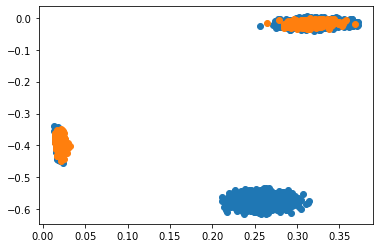

In [6]:
_, _, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g
proj_gen = torch.mm(si.T, V_g).cpu().numpy()/myRBM.Nv**0.5
proj_data =torch.mm(torch.tensor(data, device= device, dtype = dtype), V_g).cpu()/myRBM.Nv**0.5
plt.scatter(proj_data[:,0].cpu().numpy(), proj_data[:,1].cpu().numpy());
plt.scatter(proj_gen[:,0], proj_gen[:,1])


In [7]:
nb_chain = 10 # Nb de chaines pour chaque w_hat
it_mcmc = 100 # Nb it_mcmc pour chaque chaine
it_mean = 90 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point_x = 125 # Nb de points de discrétisation pour w_hat
nb_point_y = 125
width_plus = 0.2
xmin = proj_data[:,0].min()-width_plus
xmax = proj_data[:,0].max()+width_plus
ymin = proj_data[:,1].min()-width_plus
ymax = proj_data[:,1].max()+width_plus
nb_point = nb_point_x*nb_point_y

In [8]:
x_grid = np.linspace(xmin, xmax, nb_point_x)
x_grid = np.array([x_grid for i in range(nb_point_y)])
x_grid = x_grid.reshape(nb_point)
y_grid = []
y_d = np.linspace(ymin, ymax, nb_point_x)
for i in range(nb_point_x):
    for j in range(nb_point_y):
        y_grid.append(y_d[i])
grid = torch.tensor([x_grid, y_grid], device = device, dtype = dtype)
grid.shape

torch.Size([2, 15625])

In [9]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
V0 = V_g
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = grid
w_hat = torch.zeros((2, nb_chain*nb_point), device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[:,i*nb_chain+j] = w_hat_b[:,i]
tmpv, tmph, vtab = TMCSample2D(start, w_hat, N, V0, it_mcmc = it_mcmc, it_mean=it_mean)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.0010480880737304688


In [10]:
y = torch.tensor(torch.mm(vtab.T, V0)[:,:2].cpu())/myRBM.Nv**0.5
newy = torch.tensor([torch.mean(y[i*nb_chain:i*nb_chain+nb_chain,:], dim = 0).cpu().numpy() for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b = w_hat_b.cpu().numpy()

<ipython-input-10-f6dad6b7333e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.mm(vtab.T, V0)[:,:2].cpu())/myRBM.Nv**0.5


In [11]:
grad_pot = newy.T-w_hat_b
square = torch.zeros(2, nb_point_x, nb_point_y)
w_hat_tmp = np.zeros((2, nb_point_x, nb_point_y))
for i in range(0,grad_pot.shape[1], nb_point_x):
        #print("I : ", i/nb_point_x)
        #print("s : ", (i*nb_point_x))
        #print("e : ", (i*nb_point_x+nb_point_x))
        w_hat_tmp[:,:,int(i/nb_point_x)] = w_hat_b[:, i:(i+nb_point_x)]
        square[:,:, int(i/nb_point_x)] = grad_pot[:,i:(i+nb_point_x)]
#square = grad_pot.reshape(2,nb_point_x, nb_point_y)
w_hat_x = np.linspace(xmin, xmax, nb_point_x)
w_hat_y = np.linspace(ymin, ymax, nb_point_y)

#calcul de l'intégrale sur w_1
res_x = np.zeros((nb_point_x,nb_point_y))
for j in range(1,nb_point_y):
    for i in range(1, nb_point_x):
        res_x[i,j] = simps(square[0,:i,j].cpu().numpy(), w_hat_x[:i])

res_x = res_x


#calcul de l'intégrale sur w_2
res_y = np.zeros((nb_point_x, nb_point_y))
for i in range(1, nb_point_x):
    for j in range(1, nb_point_y):
        res_y[i,j] = simps(square[1,i,:j].cpu().numpy(), w_hat_y[:j])
res_y = res_y
pot = res_x + res_y
pot = pot.T
res = np.exp(N*(pot-np.max(pot)))

In [12]:
#LE CALCUL DE LA CONSTANTE EST CORRECT
const = np.zeros(res.shape[0]-1)
for i in range(1, res.shape[0]):
    const[i-1] = simps(res[:,i], w_hat_y)
const = simps(const, w_hat_y[:-1])
p_m = res/const

In [13]:
tmp = np.zeros(p_m.shape[0]-1)
for i in range(1, p_m.shape[0]-1):
    tmp[i-1] = simps(p_m[:,i], w_hat_y)
tmp = simps(tmp, w_hat_y[:-1])
print("Integrale de la proba sur l'espace : ", tmp)

Integrale de la proba sur l'espace :  0.9999999999998638


0.0

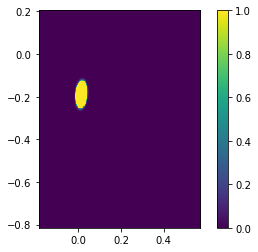

In [14]:
plt.imshow(p_m, vmax = 1, extent = [xmin, xmax, ymin, ymax])
plt.colorbar()
p_m.min()

<ipython-input-15-7896322d8dbc>:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(p_m), extent = [xmin, xmax, ymin, ymax])


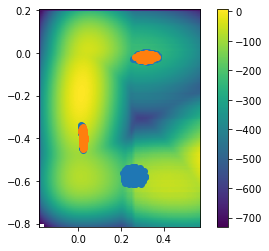

In [15]:
plt.scatter(proj_data[:,0].cpu().numpy(), proj_data[:,1].cpu().numpy());
plt.scatter(proj_gen[:,0], proj_gen[:,1])
plt.imshow(np.log(p_m), extent = [xmin, xmax, ymin, ymax])

plt.colorbar()

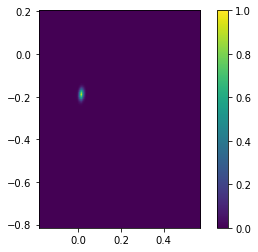

In [16]:
plt.imshow(res, extent = [xmin, xmax, ymin, ymax])
plt.colorbar()

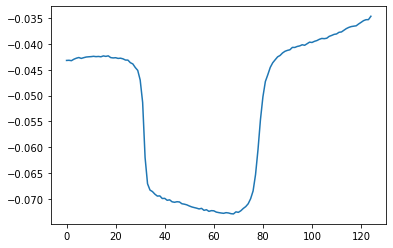

In [17]:
plt.plot(square[0,50,:]);

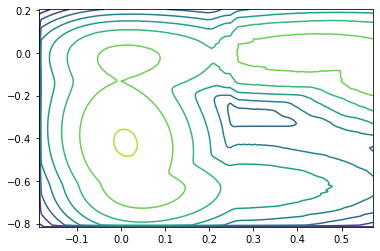

In [18]:


X, Y = np.meshgrid(w_hat_x, w_hat_y)
plt.contour(X,Y,pot)

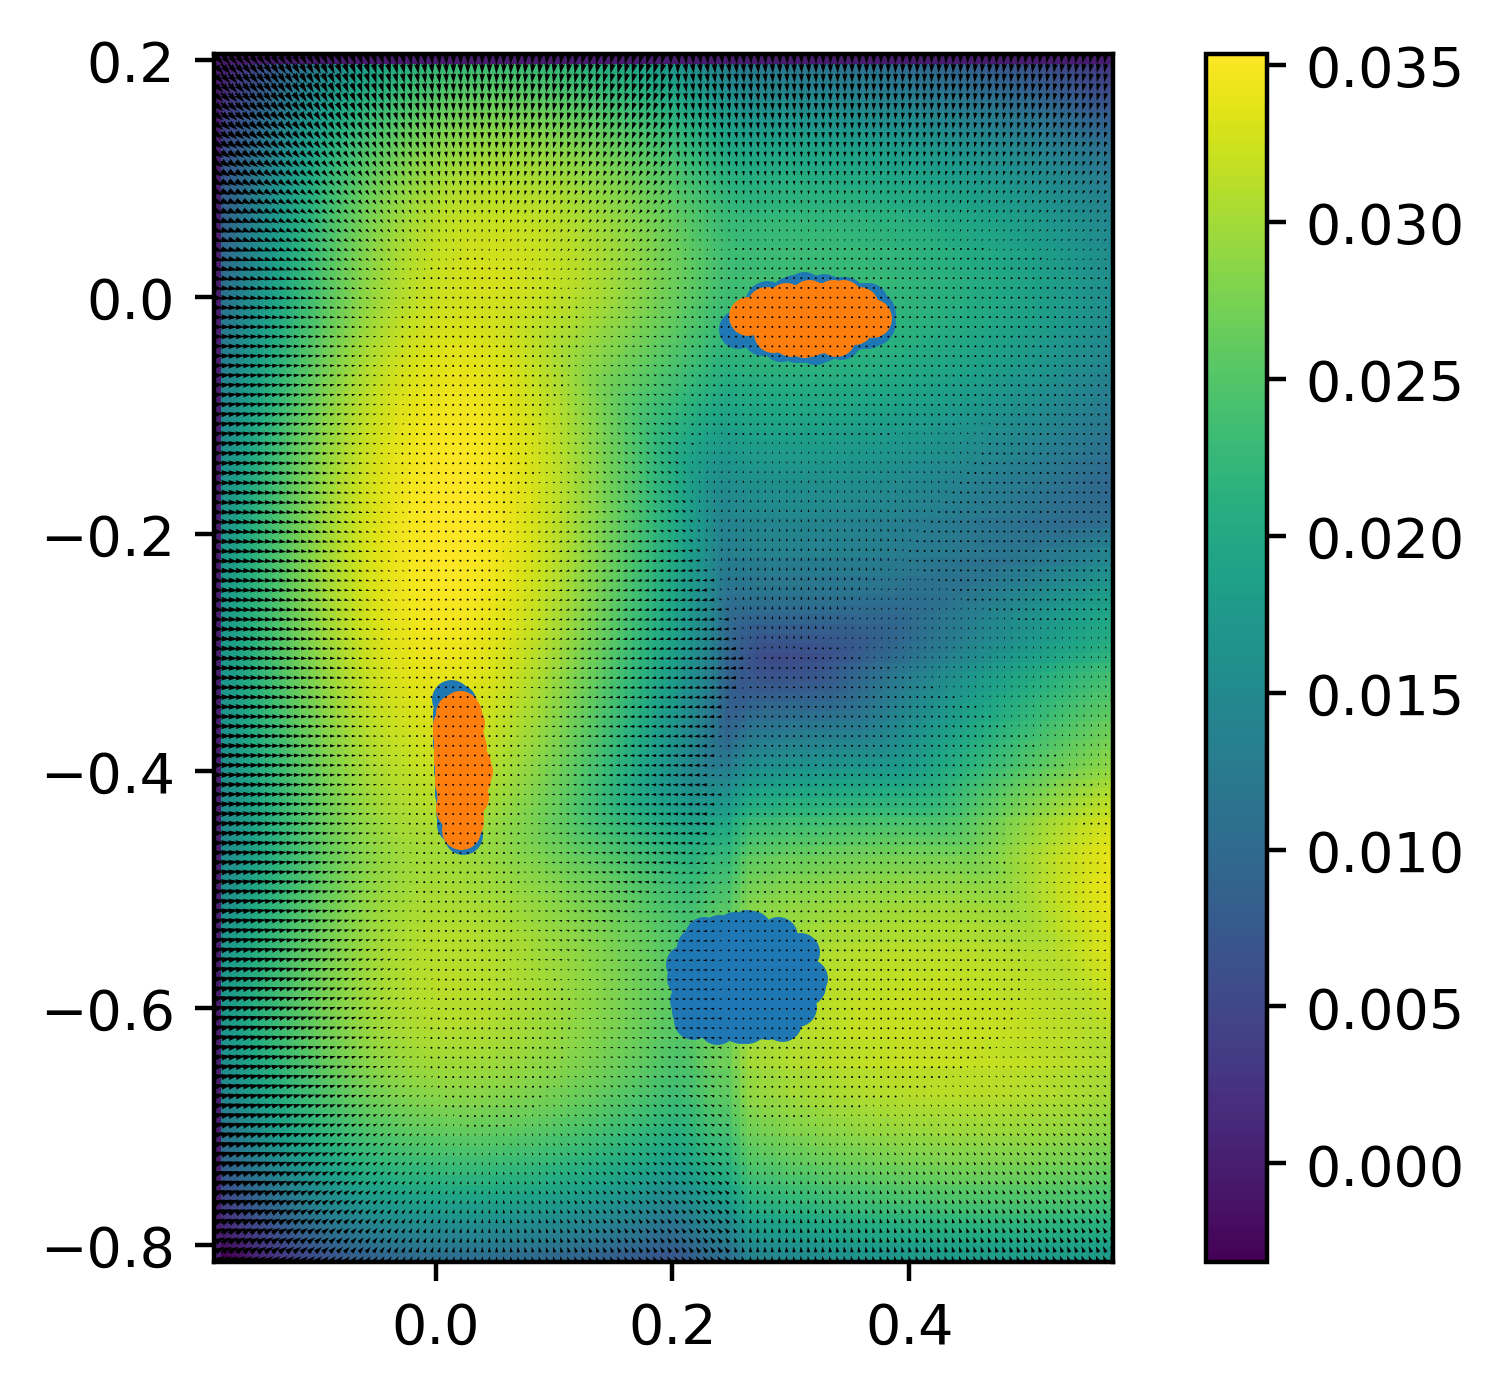

In [19]:
plt.ion()
plt.figure(dpi = 400)

plt.scatter(proj_data[:,0].cpu().numpy(), proj_data[:,1].cpu().numpy());
plt.scatter(proj_gen[:,0], proj_gen[:,1])
plt.quiver(w_hat_b[0,:], w_hat_b[1,:], grad_pot[0,:], grad_pot[1,:])
plt.imshow(pot, extent = [xmin, xmax, ymin, ymax] )

#plt.quiver(w_hat_b[0,:], w_hat_b[1,:], pot.reshape(2500)[:], pot.reshape(2500)[1,:])
plt.colorbar()
plt.show()

In [20]:
plt.plot(tmp.T[,:])

SyntaxError: invalid syntax (<ipython-input-20-ab71f7a51037>, line 1)

In [ ]:
plt.imshow(tmpres[1,:,:])
plt.colorbar()

In [ ]:
res=np.zeros((2,w_hat_b.shape[1]-1))


for i in range(1,w_hat_b.shape[1]):
    for j in ra
    res[0,i-1] = simps(newy[:i, 0]-w_hat_b[0,:i], w_hat_b[0,:i])
for i in range(1, w_hat_b.shape[1]-1):
    res[1,i-1]=
const = simps(np.exp(N*res), w_hat_b[:,:-1])
p_m = np.zeros(res.shape)
p_m[0,:] = np.exp(N*res)[0,:]/const[0]
p_m[1,:] = np.exp(N*res)[1,:]/const[1]

print(simps(p_m, w_hat_b[:,:-1]))
potential = res + (1/N)*np.log(const)

In [ ]:
simps(newy[:i, 0]-w_hat_b[0,:i], w_hat_b[0,:i])